In [34]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [bin(int(el, base=16))[2:] for el in msg]
    msg = ["0" * (8 - len(el)) + el for el in msg]
    return "".join(msg)
    return msg


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [hex(int(el, 2))[2:].zfill(2) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = str(bin(image[i]))[2:].zfill(8)
        new_byte = byte[:-nbits] + chunk
#         print(f'{byte} + {chunk} = {new_byte}')
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = str(bin(image[i]))[2:].zfill(8)
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

Widzimy, że dla pliku PNG nasza wiadomość pozostała niezmieniona, ale obrazek zapisany w formacie JPG utracił tajną wiadomość. Tak jak było to wspomniane wyżej, wynika to z faktu użycia kompresji stratnej. W zwiazku z tym, czy można zapisać w formacie JPEG tajną wiadomość? Tak i o tym opowiemy sobie później, ale najpierw...

Marc Chagall - "Me and the village"


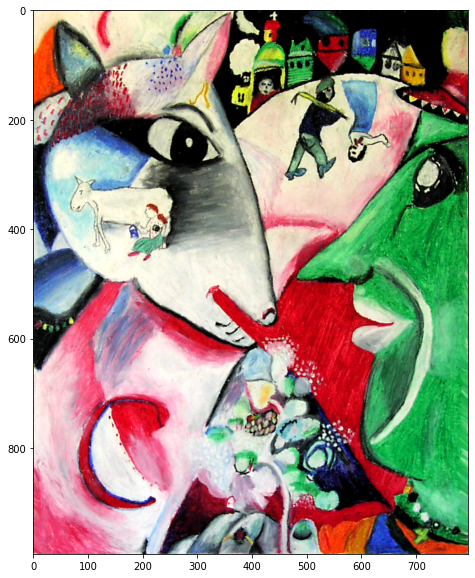

In [35]:
# Zadanie 1
message = "Marc Chagall - \"Me and the village\""
original_image = load_image(path='images/chagall.png')

message = encode_as_binary_array(message)
image_with_message = hide_message(image, message, nbits=1)

save_image("images/chagall_with_message.png", image_with_message)
image_with_message_image = load_image(path='images/chagall_with_message.png')

secret_message = decode_from_binary_array(reveal_message(image_with_message, nbits=n, length=len(message)))
plt.imshow(image_with_message_image)
print(secret_message)


In [36]:
# Zadanie 2
def number_of_bytes_in_image(image):
    x,y,z = image.shape
    return x*y*z

def number_of_bits(string):
    return len(string) * 8

def generate_text(text, num_of_bytes, ratio=0.8):
    message = ''
    while (number_of_bits(message) / num_of_bytes < 0.8):
        message += text
    
    return message

num_of_bytes = number_of_bytes_in_image(original_image)
text = generate_text('W4 jest najlepsze! ', num_of_bytes)
print(number_of_bits(text) / num_of_bytes)


0.8000438690845282


Text(0.5, 1.0, 'nbits=8')

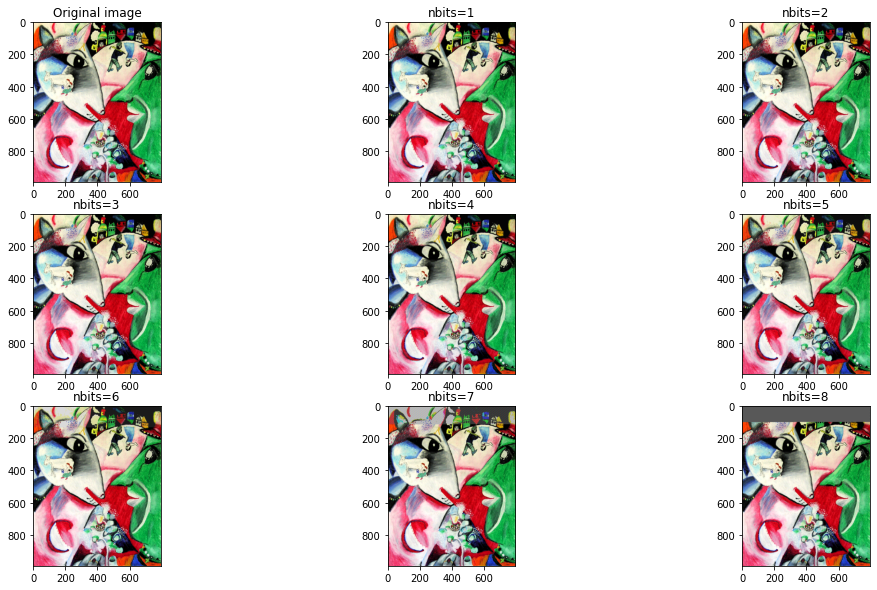

In [44]:
# plt.rcParams["figure.figsize"] = (30,30)
message = encode_as_binary_array(text)

images = []
for i in range(1, 9):
    img = hide_message(image, message, nbits=i)
    images.append(img)
    save_image(f"images/chagall_with_message_nbits_{i}.png", img)


f, ar = plt.subplots(3,3)
ar[0,0].imshow(original_image)
ar[0,0].set_title("Original image")

ar[0,1].imshow(images[0])
ar[0,1].set_title("nbits=1")

ar[0,2].imshow(images[1])
ar[0,2].set_title("nbits=2")

ar[1,0].imshow(images[2])
ar[1,0].set_title("nbits=3")

ar[1,1].imshow(images[3])
ar[1,1].set_title("nbits=4")

ar[1,2].imshow(images[4])
ar[1,2].set_title("nbits=5")

ar[2,0].imshow(images[5])
ar[2,0].set_title("nbits=6")

ar[2,1].imshow(images[6])
ar[2,1].set_title("nbits=7")

ar[2,2].imshow(images[7])
ar[2,2].set_title("nbits=8")

# works, but makes mess 
# secret_message = decode_from_binary_array(reveal_message(images[6], nbits=7, length=len(message)))
# print(secret_message)

### Ukryjmy obrazek w obrazku

Ukryć inny obrazek w obrazku można na wiele sposobów. Na przykład, możemy wygenerować obraz o ograniczonej liczbie kolorów (ograniczonej do liczby najmłodszych bitów, które będziemy zmieniać) i niejako zatopić jeden obraz w drugim (podobnie jak było to robione wyżej z wiadomością tekstową). Przy takim podejściu problemem może być rozmiar obrazka (musiałby on być nie większy niż obraz-nośnik) i przypisanie kolorów do danych wartości (żeby ograniczyć paletę kolorów i tym samym zmniejszyć rozmiar obrazka moglibysmy użyć algorytmu K-means - instrukcja 2). Problem przypisania wartości do kolorów można rozwiązać poprzez ich tablicę - jest to tzw. tryb indeksowany, w którym obraz składa się z dwóch macierzy: listy kolorów i obrazu właściwego, którego komórki zawierają nie wartości kanałów a indeksy do listy kolorów. Formatem działającym w tym trybie jest np. GIF (przy okazji, to w tablicy kolorów też można ukryć informacje wykorzystując fakt, że kolejność barw nie ma znaczenia). Oczywiście można też prościej (i prawdopodobnie o wiele sensowniej) potraktować plik jako to czym jest w rzeczywistości (ciągiem bitów) i po prostu zapisać je do obrazka, tak jak to robiliśmy wyżej z tekstem. W ten sposób możemy np. zapisać obraz JPG w obrazie PNG (obraz JPG jest znacznie mniejszy):

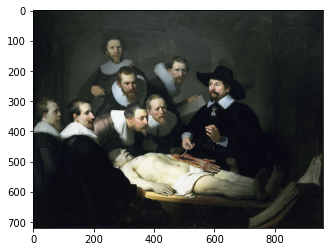

In [3]:
def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
        
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]
    secret_img = [bin(int(el, base=16))[2:].zfill(8) for el in secret_img]
    secret_img = "".join(secret_img)
    return hide_message(image, secret_img, nbits), len(secret_img)

image = load_image("images/rembrandt.png")
image_with_secret, length_of_secret = hide_image(image, "images/spanish.jpg", 1)
plt.imshow(image_with_secret)

Na obrazku nie widać śladu wiadomości (zresztą zajmuje ona tylko drobny fragment powyższego obrazu). Proszę poeksperymentować z wartością `nbits`. Stworzenie funkcji, która znajduje ukryty obrazek i zapisuje go do pliku będzie jednym z zadań.

## Zmiana wartości w przekształconej dziedzinie.

Zgodnie z obietnicą, spróbujmy ukryć wiadomość w pliku z kompresją JPEG. Najpierw przypomnijmy sobie jak wygląda algorytm kodowania JPEG:

1. Konwersja modelu barw: RGB -> YCbCr.
2. Przeskalowanie w dół (stratne) macierzy składowych Cb i Cr.
3. Podział obrazu na bloki o rozmiarze 8x8.
4. Wykonanie dyskretnej transformacji cosinusowej na każdym bloku obrazu.
5. Podzielenie każdego bloku obrazu przez macierz kwantyzacji.
6. Zaokrąglenie wartości w każdym bloku do liczb całkowitych.
7. Zwinięcie każdego bloku 8x8 do wiersza 1x64 – algorytm ZigZag.
8. Zakodowanie danych obrazu – m.in. algorytmem Huffmana.

Ostatnim krokiem, w którym rzeczywiście tracimy informacje, jest krok 6. W związku z tym, większość technik ukrywania wiadomości w plikach JPEG polega na zmianie bloków obrazu (kanału) właśnie po kwantyzacji (znajdujemy się w dziedzinie częstotliwości). Najprostszą metodą jest znowu zmiana najmłodszego bitu wartości w tych macierzach (LSB), ale tym razem nie będziemy mogli zmieniać:

1. zer - ponieważ może to znacząco zwiększyć wielkość pliku wyjściowego,
2. jedynek - ponieważ mogą się zmienić w zera.

Po zmianie bloków należałoby kontynuować algorytm (krok 7 i 8) i zapisać dane do pliku, ale że implementacja pełnego formatu danych wychodzi poza zakres tego kursu, to zamiast tego cofiemy się z powrotem do formatu RGB (wykonując odwrotne kroki w odwrotnej kolejności) i zapiszemy obraz korzystając z biblioteki. Wiadomość będziemy kodować jedynie w kanale Y.

In [4]:
"""Function definitions that are used in JPEG LSB steganography."""
from scipy.fftpack import dct
from scipy.fftpack import idct
from PIL import Image

# Quantization matrix 
QY = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
              [12, 12, 14, 19, 26, 48, 60, 55], 
              [14, 13, 16, 24, 40, 57, 69, 56], 
              [14, 17, 22, 29, 51, 87, 80, 62], 
              [18, 22, 37, 56, 68, 109, 103, 77], 
              [24, 35, 55, 64, 81, 104, 113, 92], 
              [49, 64, 78, 87, 103, 121, 120, 101], 
              [72, 92, 95, 98, 112, 100, 103, 99]], dtype=np.float64)
QY = np.ceil(QY / 2)


def dct2(array):
    """Discrete cosine transform."""
    return dct(dct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def idct2(array):
    """Inverse discrete cosine transform."""
    return idct(idct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def split_channel_to_blocks(channel):
    """Splits channel into blocks 8x8"""
    blocks = []
    size = 8
    for i in range(0, channel.shape[0], 8):
        for j in range(0, channel.shape[1], 8):
            blocks.append(channel[i:i + 8, j:j + 8])
    return blocks


def merge_blocks_to_channel(blocks, width):
    """Merge 8x8 blocks into """
    step = int(width / 8)
    rows = []
    for i in range(0, len(blocks), step):
        rows.append(np.concatenate(blocks[i:i + step], axis=1))
    channel = np.concatenate(rows, axis=0)
    return channel


def hide_message(blocks, message):
    """Hide a message in blocks."""
    blocks = [b.astype(np.int32) for b in blocks]
    i = 0
    for nb in range(len(blocks)):
        for y, x in zip(range(1), range(1)):
            value = blocks[nb][y, x]
            if i >= len(message):
                break
            if value == 0 or value == 1:
                continue
            m = message[i]
            i += 1
            v = np.binary_repr(value, width=32)
            new_value = np.int32(int(v[:-1] + m, 2))
            blocks[nb][y, x] = new_value
        else:
            continue
        break
    if i < len(message):
        print("Could not encode whole message")
    return blocks


def reveal_message(blocks, length=0):
    """Reveal message from blocks.
    
    length: length of the message in bits
    """
    blocks = [b.astype(np.int32) for b in blocks]
    message = ""
    i = 0
    for block in blocks:
        for y, x in zip(range(1), range(1)):
            value = block[y, x]
            if value == 0 or value == 1:
                continue
            message += np.binary_repr(value, width=32)[-1]    
            i += 1
            if i >= length:
                return message
            

def y_to_dct_blocks(Y):
    """Convert Y to quantized dct blocks."""
    Y = Y.astype(np.float32)
    blocks = split_channel_to_blocks(Y)
    blocks = [dct2(block) for block in blocks]
    blocks = [np.round(block / QY) for block in blocks]
    return blocks


def dct_blocks_to_y(blocks, image_width):
    """Convert quantized dct blocks to Y."""
    blocks = [block * QY for block in blocks]
    blocks = [idct2(block) for block in blocks]
    Y = merge_blocks_to_channel(blocks, image_width).round()
    return Y


In [5]:
original_image = load_image("images/rembrandt.png", True)
message = "Ala ma kota"

# Convert to YCbCr
image = cv.cvtColor(original_image, cv.COLOR_RGB2YCrCb)

# Split channels
Y = image[:, :, 0]
Cr = image[:, :, 1]
Cb = image[:, :, 2]

# Convert Y to quantized dct blocks
blocks = y_to_dct_blocks(Y)

# Hide message
blocks = hide_message(blocks, encode_as_binary_array(message))

# Check if message is there
message_from_dct = reveal_message(blocks, len(encode_as_binary_array(message)))
print("Message from dct: ", decode_from_binary_array(message_from_dct))

# Retrive Y
Y = dct_blocks_to_y(blocks, image.shape[1])

# Merge channels
image = np.stack([Y, Cr, Cb], axis=2)

# Convert to RGB
image = np.clip(image, 0, 255)
image = image.astype(np.uint8)
image_with_message = cv.cvtColor(image, cv.COLOR_YCrCb2RGB)

# Save image as JPEG
save_image("images/image_with_message2.jpg", image_with_message)

# Load saved image
loaded_image_with_message = load_image("images/image_with_message2.jpg", True)

# Retrive message from loaded image
loaded_image_with_message = cv.cvtColor(loaded_image_with_message, cv.COLOR_RGB2YCrCb)
Y = loaded_image_with_message[:, :, 0]
Cr = loaded_image_with_message[:, :, 1]
Cb = loaded_image_with_message[:, :, 2]
blocks = y_to_dct_blocks(Y)
message_from_dct = reveal_message(blocks, len(encode_as_binary_array(message)))
print("Message from JPEG file: ", decode_from_binary_array(message_from_dct))


# Show all images
f, ar = plt.subplots(3, dpi=150)
f.tight_layout()
ar[0].imshow(original_image)
ar[0].set_title("Original image")
ar[1].imshow(image_with_message)
ar[1].set_title("Image with message")
ar[2].imshow(image_with_message_png)
ar[2].set_title("Image with message loaded from JPEG")

Widzimy, że wiadomość została w większości zachowana, ale dlaczego tylko w większości (macierz kwantyzacji funkcji zapisującej jest taka sama jak ta, której użyliśmy my)? Kiedy po zapisaniu wiadomości w komórkach macierzy DCT dokonujemy transformacji odwrotnej, to mogą się w niej pojawić wartości ujemne, które następnie przycinamy do zadanego zakresu (od 0 do 255). W związku z powyższym, jeżeli jeszcze raz przejdziemy procedurę algorytmu JPEG, to będziemy kodowali inny obrazek niż na początku i część wartości może zmienić się na tyle, żeby pokonać próg zaokrąglania w górę/dół (0.5) - powoduje to zmianę pojedynczych bitów. Aby uchronić się przed tym zjawiskiem należałoby kontunuować algorytm JPEG (krok 7 i 8) i samemu stworzyć funkcję zapisującą do pliku (alternatywnie można skorzystać z jakiejś gotowej biblioteki i wniej nadpisać funkcje odpowiedzialną za kwantyzacje macierzy).

Na szczęście błędy powinny być drobne i przy odrobinie cierpliwości można je również (przynajmniej częściowo) zlikwidować dostosowując macierz kwantyzacji QY. Proszę zmienić linijkę `QY = np.ceil(QY / 2)` na `QY = np.ceil(QY / 2 + 2)` - odczytana wiadomość powinna być wtedy poprawna.


Jeżeli nie udało Ci się znaleźć ukrytej wiadomości w drugim paragrafie to dobrze - żadnej tam nie było xD

# Zadania

1. (3.0) Korzystając z podanych wyżej funkcji ukryć dowolną wiadomość w dowolnym obrazku.
2. (3.5) Korzystając z kodu znajdującego się w punkcie `Ukryjmy tekst w obrazku` wygenerować i wyświetlić szerego obrazków z ukrytą wiadomością:
    1. Wiadomość dla nbits=1 ma zajmować znakomitą większość obrazka (powyżej 75%).
    2. Każdy kolejny obrazek należy generować z większą wartością nbits (do 8) - będzie 8 obrazków z wiadomością.
    3. Dla każdego obrazka należy policzyć MSE z oryginałem.
    4. Wartości MSE należy umieścić na wykresie (wykres ten należy wyświetlić w notebooku), w którym oś x stanowić będzie nbits.
    5. Źródło tekstu jest dowolne, ale proponuję użyć czegoś w stylu (https://pypi.org/project/lorem/).
    6. Do rysowania wykresu można wykorzystać funkcję `matplotlib.pyplot.plot`
3. (4.0) Przerobić funkcje `reveal_message` i `hide_message` z punktu `Zmiana wartości pikseli` w taki sposób, aby pozwalały zapisywać i odczytywać wiadomość zaczynająć od zadanej pozycji (funkcje można napisać od nowa, ale wyjście ma pozostać niezmienione). Sygnatury funkcji powinny wyglądać następująco (spos to pozycja początkowa):

    1. `def hide_message(image, message, nbits=1, spos=0)`
    2. `def reveal_message(image, nbits=1, length=0, spos=0):`

4. (4.5) Napisać program, który odzyska obrazek z obrazka zapisanego w punkcie 'Ukryjmy obrazek w obrazku'. Funkcja dekodująca (odnajdująca wiadomość) powinna przyjmować następujące parametry: 
    1. image - obrazek z ukrytym obrazkiem
    2. length - długość ukrytego obrazka
    3. nbits - liczba najmłodszych bitów użyta do zakodowania obrazka
5. (5.0) Przekazywanie długości ukrytej wiadomości do funkcji odzyskującej nie jest ładnym rozwiązaniem. W przypadku tajnego tekstu można by było zapisywać na jego końcu znak `\0`, który oznaczałby koniec ciągu znaków. W przypadku ukrytych obrazków można by było wykorzystać standardowy nagłówek i stopkę pliku (i tego dotyczy to zadanie).

    Należy zmodyfikować program napisany w poprzednim punkcie tak, aby funkcja dekodująca nie potrzebowała parametru `length`
    
    Uwagi:
    - w zadaniu wymagane jest jedynie szukanie stopki (plik może być na początku obrazka)
    - istnieje mała szansa, że stopka będzie występowała naturalnie w danych - należy wziąć pozycję pierwszego wystąpnienia (w tym i większości przypadków to zadziała, ale normalnie powinno się dokładniej przeanalizować nagłówek). 